# Práctica 4: Introducción a la Visualización de Redes (notebook preliminario)

Por Eduardo Graells-Garrido (Barcelona Supercomputing Center, <eduardo.graells@bsc.es>).

En este notebook haremos una pausa respecto al data set a trabajar.

Aprenderemos a visualizar redes con el módulo `aves` a través de [graphtool](graph-tool.skewed.de/), una biblioteca para trabajar con redes en Python.

Los propósitos de esta clase son los siguientes:

  1. Cargar una red.
  2. Explorar como visualizarla.
  3. Definir una tarea y usar visualización para responderla.
  
Debemos tener la biblioteca `graph_tool` instalada en nuestro entorno. Recuerden utilizar el comando `make conda-update-env` para actualizar sus entornos.

Como data set de prueba utilizaremos la Red de Jazz que se encuentra en [Colección de Redes de Koblenz](http://konect.uni-koblenz.de/networks/arenas-jazz). Se encuentra disponible en el repositorio `aves`, en la carpeta `data/external/arenas-jazz`.
  
---

### Preámbulo

Aquí configuramos el notebook para que incluya las bibliotecas que usaremos.

In [1]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import graph_tool
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# esto configura la apariencia de los gráficos: tamaños de letra, bordes, colores base, etc.
sns.set(context='paper', font='Fira Code', style='ticks', palette='colorblind', font_scale=1.1)

In [2]:
!cat ../data/external/arenas-jazz/README.arenas-jazz

Jazz musicians network, part of the Koblenz Network Collection

This directory contains the TSV and related files of the arenas-jazz network:

This is the collaboration network between Jazz musicians.  Each node is a Jazz musician and an edge denotes that two musicians have played together in a band.  The data was collected in 2003. 


More information about the network is provided here: 
http://konect.uni-koblenz.de/networks/arenas-jazz

Files: 
    meta.arenas-jazz -- Metadata about the network 
    out.arenas-jazz -- The adjacency matrix of the network in space separated values format, with one edge per line
      The meaning of the columns in out.arenas-jazz are: 
        First column: ID of from node 
        Second column: ID of to node


Complete documentation about the file format can be found in the KONECT
handbook, in the section File Formats, available at:

http://konect.uni-koblenz.de/publications

All files are licensed under a Creative Commons Attribution-ShareAlike 2.0 G

En castellano, dice:

> Esta es una red de colaboración entre músicos y músicas de Jazz. Cada nodo es una persona y una arista implica que dos personas han interpretado música juntes en una banda. Loos datos fueron recolectados el año 2003. 

Veamos la cabecera del archivo:

In [3]:
!head ../data/external/arenas-jazz/out.arenas-jazz -n 10

% sym unweighted
1	10
1	11
1	12
1	13
1	14
1	15
1	16
1	17
1	18


El archivo que contiene la red tiene dos tipos de líneas:

- La primera, que tiene un comentario. Podemos ignorarlo.
- El resto, donde cada línea representa una arista. En ella aparecen dos números: el identificador del nodo de origen de una arista, y el identificador del nodo de destino de la misma arista.

Podemos usar `pandas` para cargar el archivo sin problemas.

In [4]:
edgelist = pd.read_csv('../data/external/arenas-jazz/out.arenas-jazz', sep='\t', skiprows=1, header=0, names=['source', 'target'])
edgelist

source  target
0          1      11
1          1      12
2          1      13
3          1      14
4          1      15
...      ...     ...
2736     185     186
2737     187     188
2738     187     189
2739     188     189
2740     193     194

[2741 rows x 2 columns]


En `graph_tool` necesitamos asignarle un número a cada nodo. Este número debe comenzar en 0. 
Como en el dataframe empieza en 1, le restaremos 1 a todos los valores del `DataFrame`.


In [5]:
edgelist = edgelist - 1

In [6]:
from aves.features.network import graph_from_pandas_edgelist

network = graph_from_pandas_edgelist(edgelist, directed=False)

In [7]:
network.num_vertices(), network.num_edges()

(198, 2741)

In [8]:
from aves.visualization.networks import SFDP
sfdp = SFDP(network)

In [9]:
sfdp.estimate_positions()

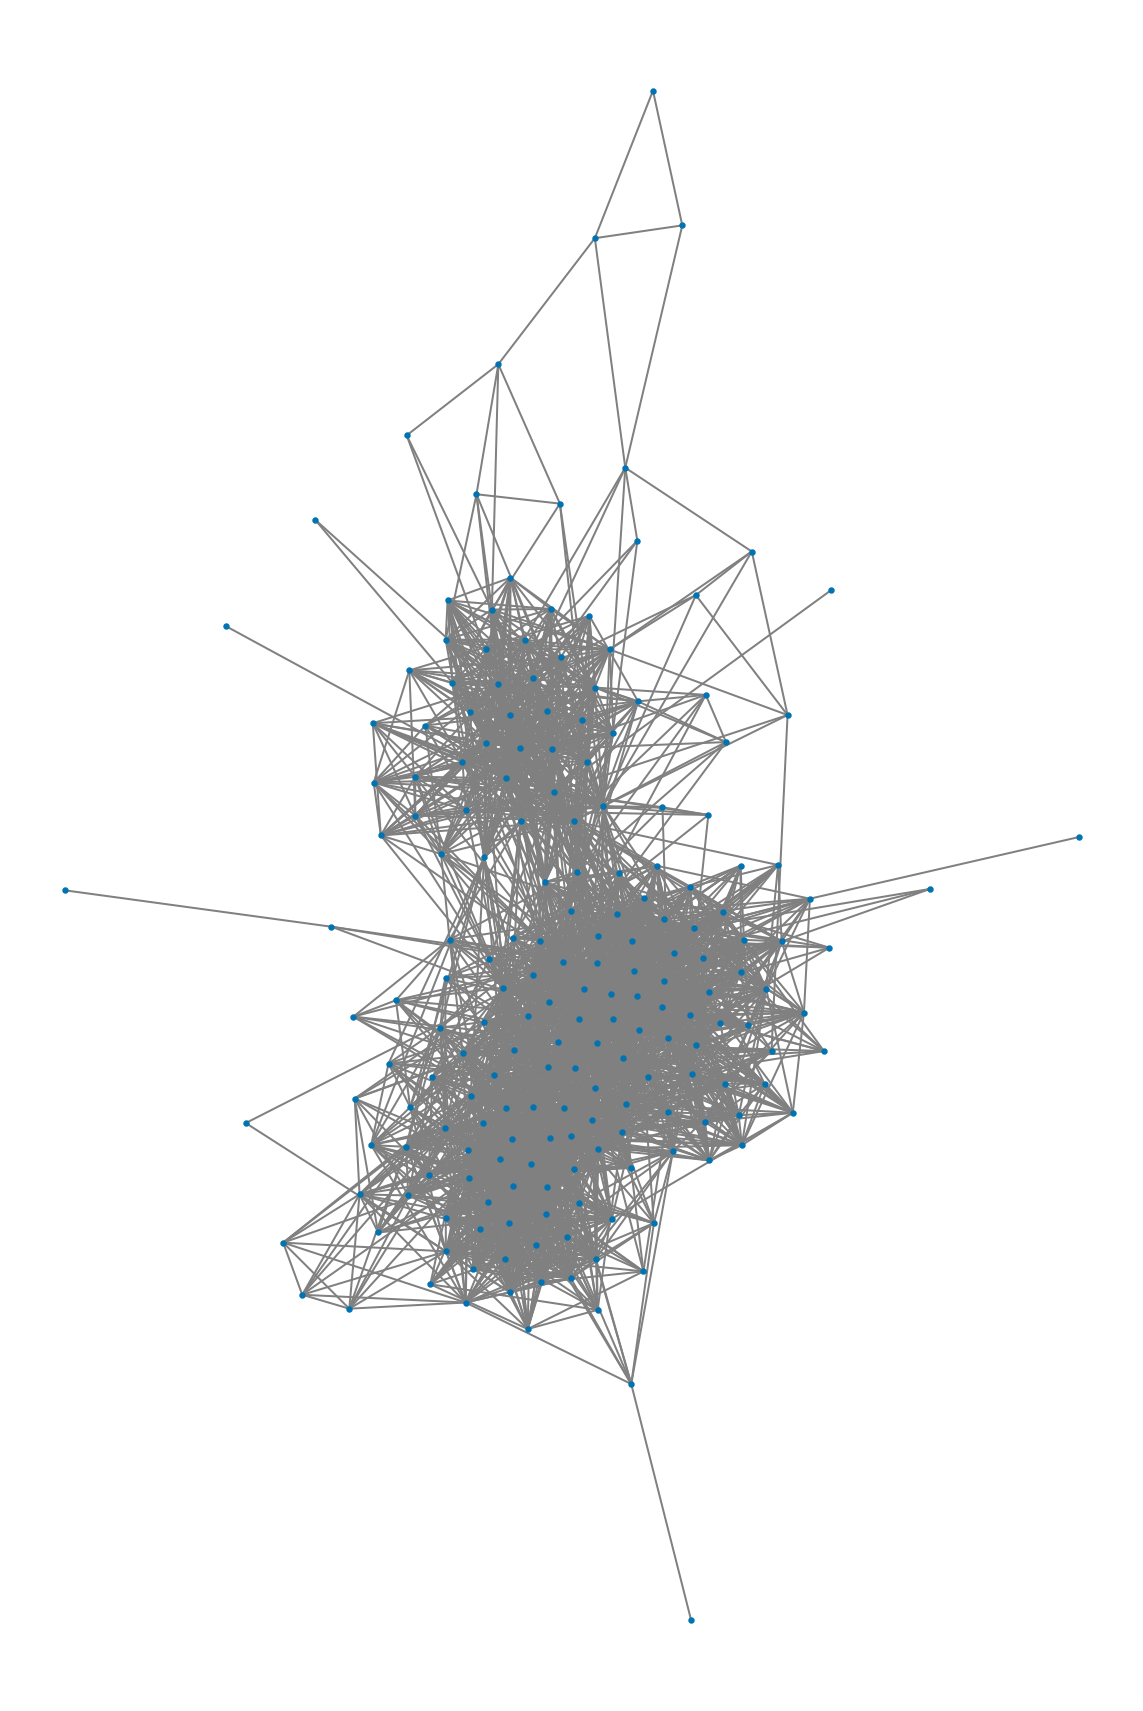

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
sfdp.plot_nodes(ax)
sfdp.plot_edges(ax)

ax.set_axis_off()
ax.set_aspect('equal')
fig.tight_layout()

Prueben ejecutando nuevamente la función `sfdp.estimate_positions()`. **¿se dieron cuenta de algo?**

**¡La red no se visualiza de la misma manera cada vez que se ejecuta la visualización!

Pongamos atención a lo siguiente:

  1. Cuando cargamos la red, en ningún momento especificamos una posición `(x, y)` para cada nodo de la red.
  2. Al visualizar la red, esas posiciones tienen que salir de algún método.
  
El método que genera las posiciones es un _algoritmo de organización_ (_layout algorithm_). Estos algoritmos posicionan los nodos en la imagen, y algunos utilizan números aleatorios para encontrar buenas posiciones de los nodos. Al ser un proceso que se ejecuta cada vez que dibujamos la red, el resultado es distinto. 

Distinto, pero _similar_: el algoritmo tiende a hacer lo mismo.

In [11]:
from aves.visualization.networks import ARF
arf = ARF(network)

In [12]:
arf.estimate_positions()

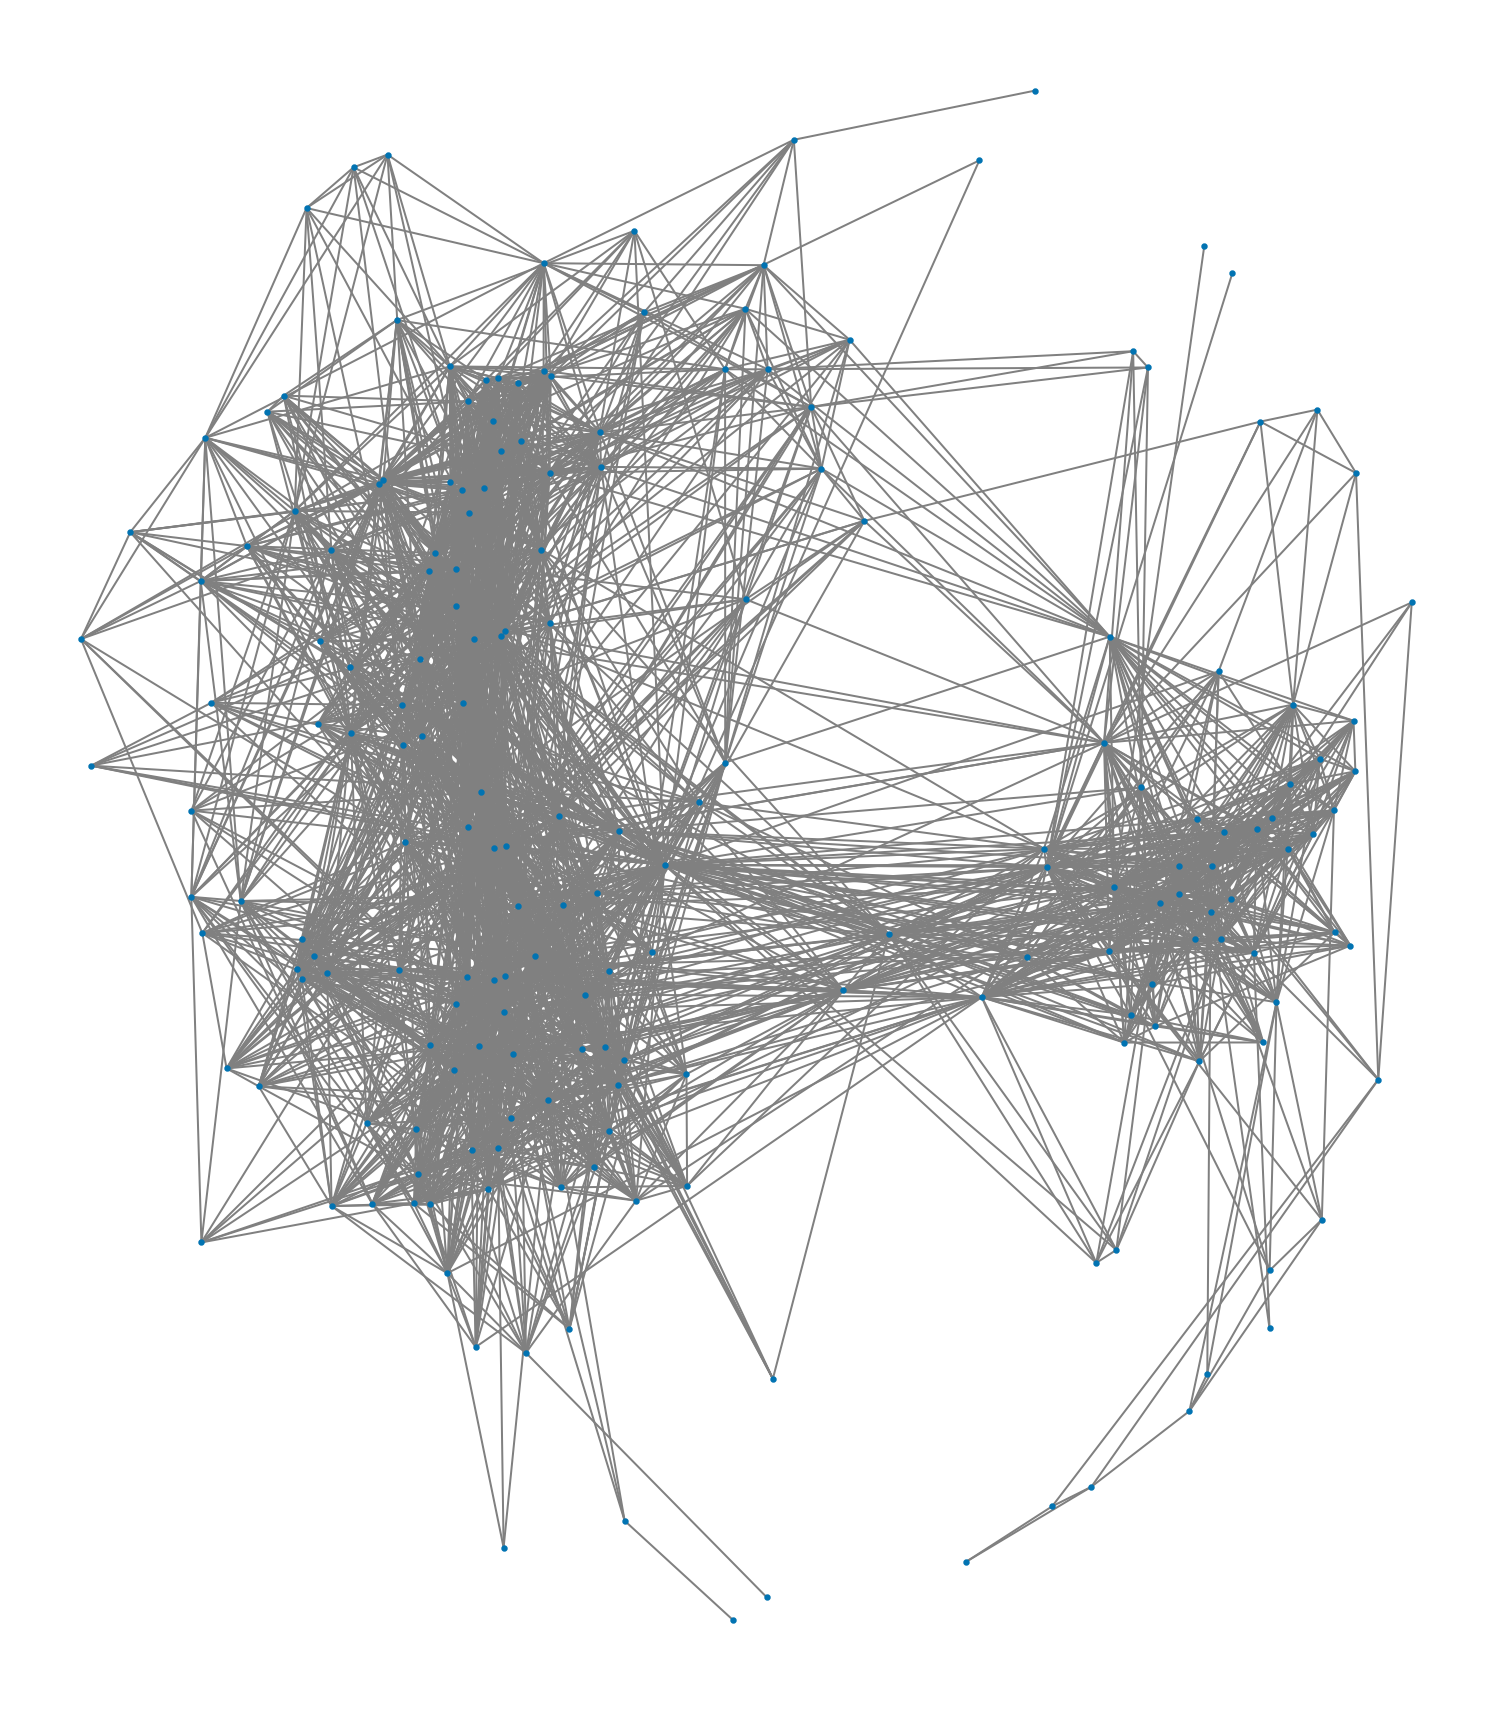

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
arf.plot_nodes(ax)
arf.plot_edges(ax)

ax.set_axis_off()
ax.set_aspect('equal')
fig.tight_layout()

## Estimar y Visualizar Caminos en la Red

Una tarea común es visualizar los caminos en una red. Por ejemplo, cada vez que pides instrucciones o caminos en una aplicación de mapas, estás observando el resultado de una estimación de caminos en la red (usualmente el camino más corto, _shortest path_). La diferencia es que en los mapas el territorio define la organización.

En el caso de una red de colaboración, una posible interpretación de un camino más corto es la secuencia de personas a las que debes contactar para conocer a alguien específico.

Veamos como graficar caminos entre dos nodos aleatorios en la red.
Para ello, importaremos el módulo `random`:

In [14]:
import random
src = random.randint(0, network.num_vertices() - 1)
dst = random.randint(0, network.num_vertices() - 1)
src, dst

(176, 139)

El método `shortest_path` de NX entrega la secuencia de nodos para ir desde un nodo origen hasta un nodo destino:parameters:

In [15]:
shortest_paths = list(graph_tool.topology.all_shortest_paths(network, src, dst))
shortest_paths

[array([176,   6, 139], dtype=uint64)]

Para graficar el camino haremos lo siguiente:

- Ejecutaremos `draw_networkx` para la red completa.
- Ejecutaremos `draw_networkx` para el camino más corto.
- En ambos casos utilizaremos opciones de apariencia distintas.

In [16]:
view = graph_tool.GraphView(network, vfilt=lambda v: v in shortest_paths[0])
view.num_vertices(), view.num_edges()

(3, 2)

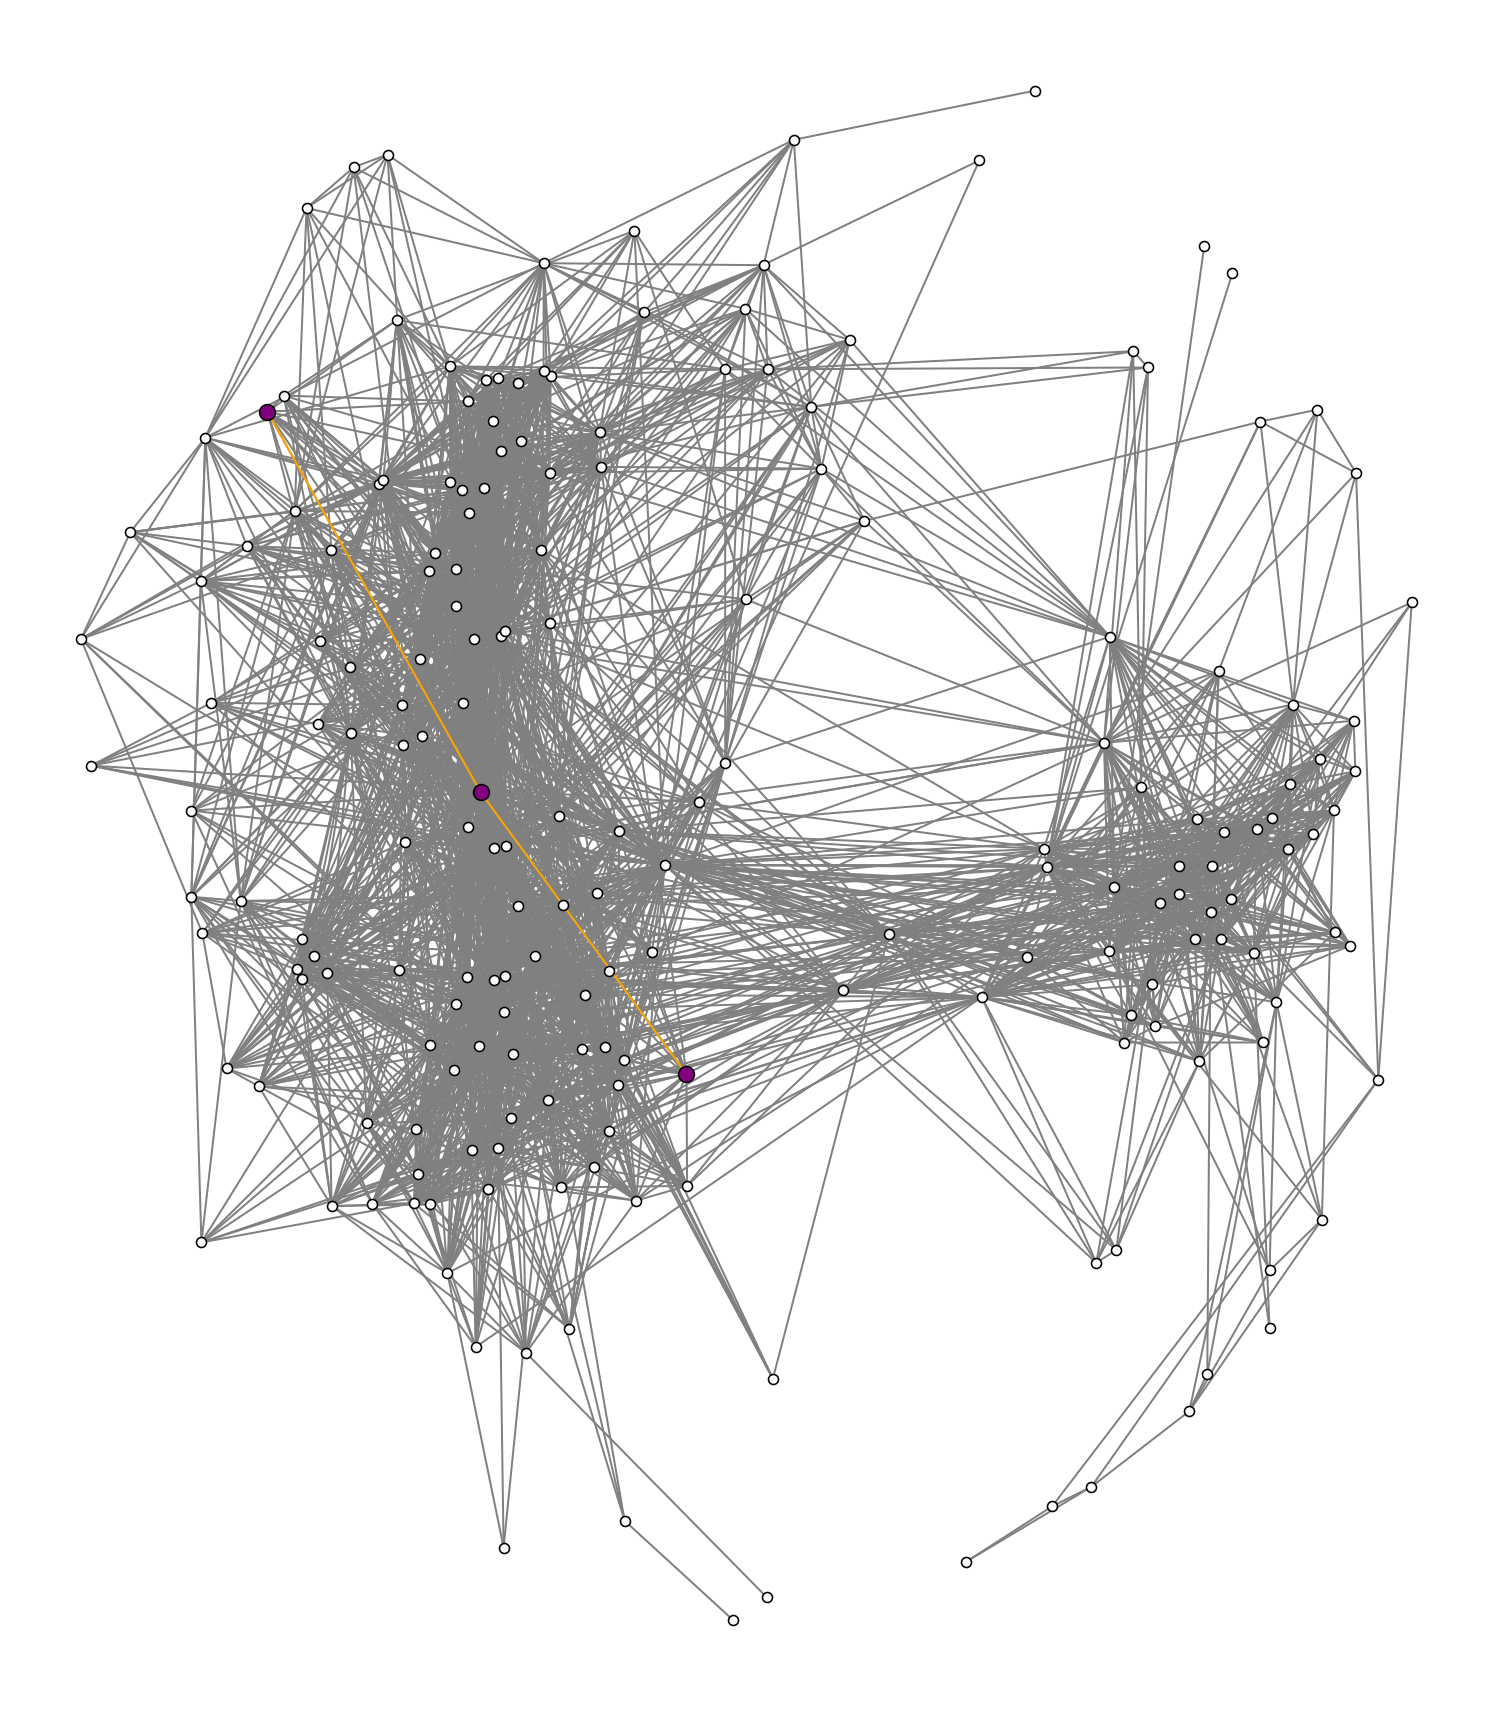

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))

# full network
arf.plot_nodes(ax, size=100, color='white', edgecolor='black')
arf.plot_edges(ax)

# shortest path with highlights
arf.plot_nodes(ax, size=250, color='purple', edgecolor='black', network=view)
arf.plot_edges(ax, color='orange', network=view)

ax.set_axis_off()
ax.set_aspect('equal')
fig.tight_layout()

Como vemos, el camino es claramente visible. Tenemos una noción de dónde está cada uno de los nodos involucrados en la red, e incluso podemos ver que al parecer el camino cruza desde una comunidad a otra.

Ahora bien, debemos tener cuidado al ver una visualización como ésta: el algoritmo de organización tiene un criterio gráfico para posicionar nodos en la imagen, una comunidad o _cluster_ en la visualización no necesariamente representa un _cluster real en la estructura_.

## Tarea: Detección de Comunidades

Una tarea común en el análisis de redes es encontrar comunidades de nodos, es decir, grupos que estén altamente conectados entre sí en comparación con las conexiones de los demás nodos. A veces estamos interesados en el comportamiento colectivo de la red, y en ese caso, podríamos analizar los patrones de comportamiento de las comunidades en vez de los de cada nodo.

En nuestro data set, la visualización sugiere que hay al menos dos comunidades. Quizás hay más. No lo sabemos aún. Pero, ¿cuál es el significado de comunidad aquí? El data set es sobre músicos de jazz que interpretan música juntos. Entonces, quizás cada comunidad se refiere a estilos específicos de interpretación, a variaciones del jazz, a ubicaciones en las que tocan música, etc.


In [18]:
from aves.visualization.networks import HierarchicalEdgeBundling

In [19]:
heb = HierarchicalEdgeBundling(network)

In [20]:
heb.estimate_blockmodel()

In [21]:
heb.build_community_graph()

level 0: 198 nodes
unique values: 20
level 1: 20 nodes
unique values: 5
level 2: 5 nodes
unique values: 1
224 223


In [22]:
heb.set_community_level()

In [23]:
heb.build_edges()

In [24]:
heb.set_community_colors(palette='colorblind')

Los nodos que están en los bordes del círculo son los músicos, y los nodos interiores son las comunidades.

Noten como los nodos están ordenados de acuerdo a las comunidades. El nodo central es una raíz artificial que agregamos en nuestra magia negra, que nos permitió darle la estructura de árbol a la red total.

El siguiente paso es generar el diccionario de posiciones solamente para los nodos de nuestra red original:

¿Qué pasa si queremos saber quién es quién en la visualización? Después de todo, las personas tienen nombres, y eso permitiría resolver más tareas con la visualización.

Este data set no contiene nombres, pero podemos asignar una etiqueta a cada persona de la red, y mostrar como se grafican las etiquetas. Para ello tendrán que desempolvar sus conocimientos de trigonometría, porque tendremos que calcular ángulos y distancias :)

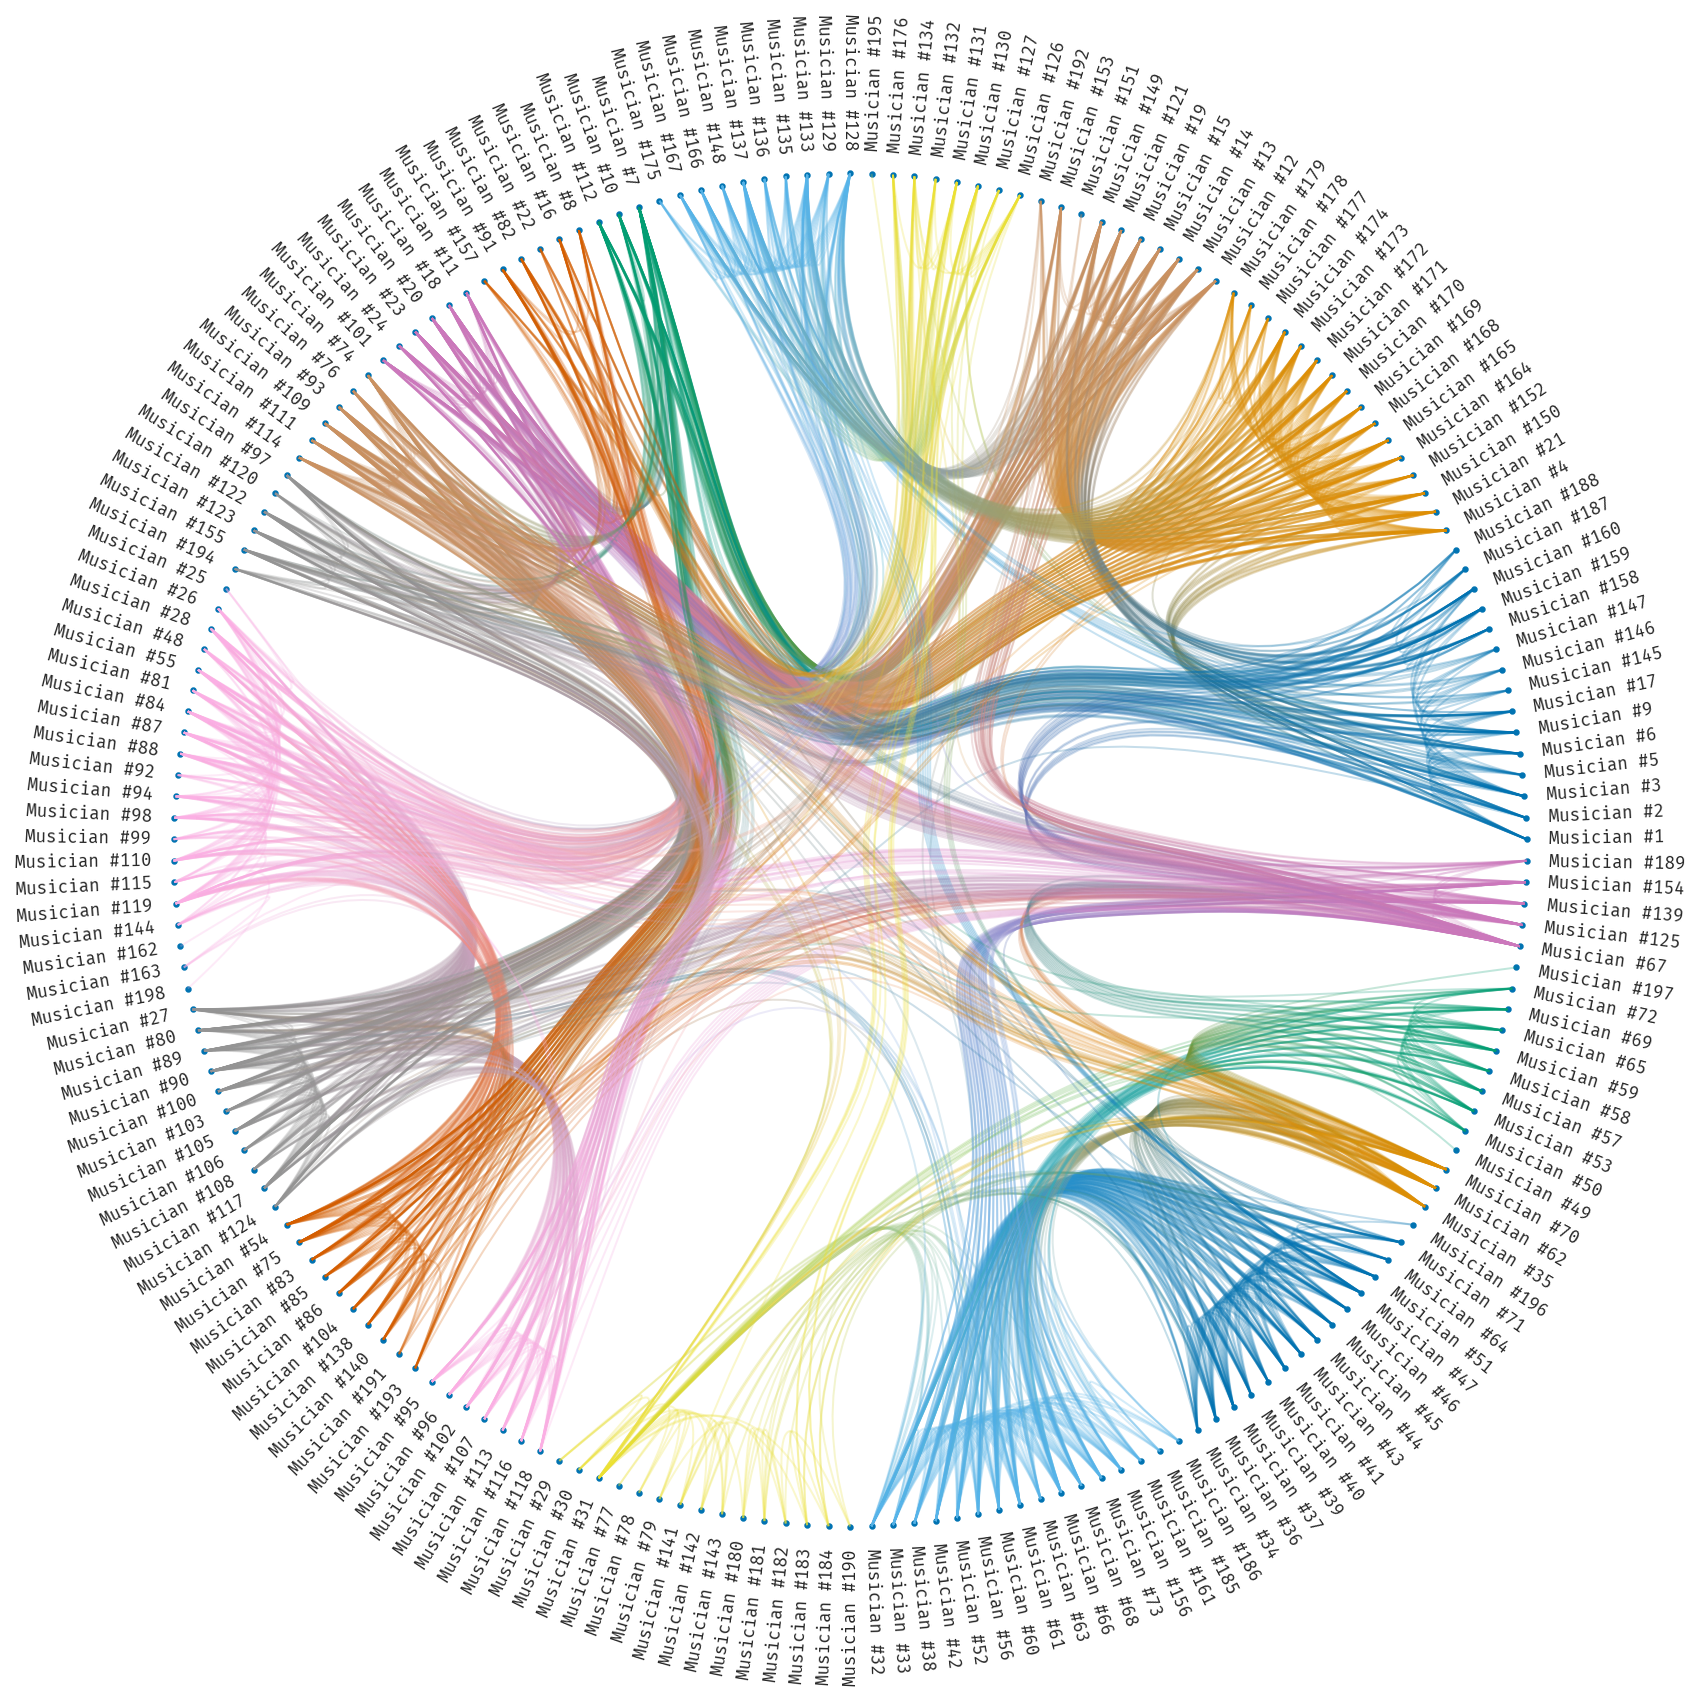

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))

# full network
heb.plot_nodes(ax)
heb.plot_edges(ax)
heb.plot_node_labels(ax, labels=[f'Musician #{i + 1}' for i in range(network.num_vertices())])

ax.set_axis_off()
ax.set_aspect('equal')
fig.tight_layout()

Increíble, ¿no? Ahora podemos ver como las comunidades se conectan entre sí y también como los miembros de una comunidad se relacionan. Vemos quienes son populares y quienes son puentes con otras comunidades. Piensen en lo útil que podría ser esto para un agente artístico.

Veamos como lucen estas comunidades en un gráfico estilo `node_link`.

In [26]:
heb.block_levels[0]

PropertyArray([ 0,  0,  0,  1,  0,  0,  2,  3,  0,  2,  4,  5,  5,  5,  5,
                3,  0,  4,  5,  4,  1,  3,  4,  4,  6,  6,  7,  6,  8,  8,
                8,  9,  9, 10, 11, 10, 10,  9, 10, 10, 10,  9, 10, 10, 10,
               10, 10,  6, 12, 12, 10,  9, 12, 13,  6,  9, 12, 12, 12,  9,
                9, 11,  9, 10, 12,  9, 14,  9, 12, 11, 10, 12,  9, 15, 13,
               15,  8,  8,  8,  7,  6,  3, 13,  6, 13, 13,  6,  6,  7,  7,
                3,  6, 15,  6, 16, 16, 17,  6,  6,  7,  4, 16,  7, 13,  7,
                7, 16,  7, 15,  6, 15,  2, 16, 15,  6, 16,  7, 16,  6, 17,
                5, 17, 17,  7, 14, 18, 18, 19, 19, 18, 18, 18, 19, 18, 19,
               19, 19, 13, 14, 13,  8,  8,  8,  6,  0,  0,  0, 19,  5,  1,
                5,  1,  5, 14, 17,  9,  3,  0,  0,  0,  9,  6,  6,  1,  1,
               19, 19,  1,  1,  1,  1,  1,  1,  1, 19, 18,  1,  1,  1,  8,
                8,  8,  8,  8,  9,  9,  0,  0, 14,  8, 13,  5, 13, 17, 18,
               10, 12,  6

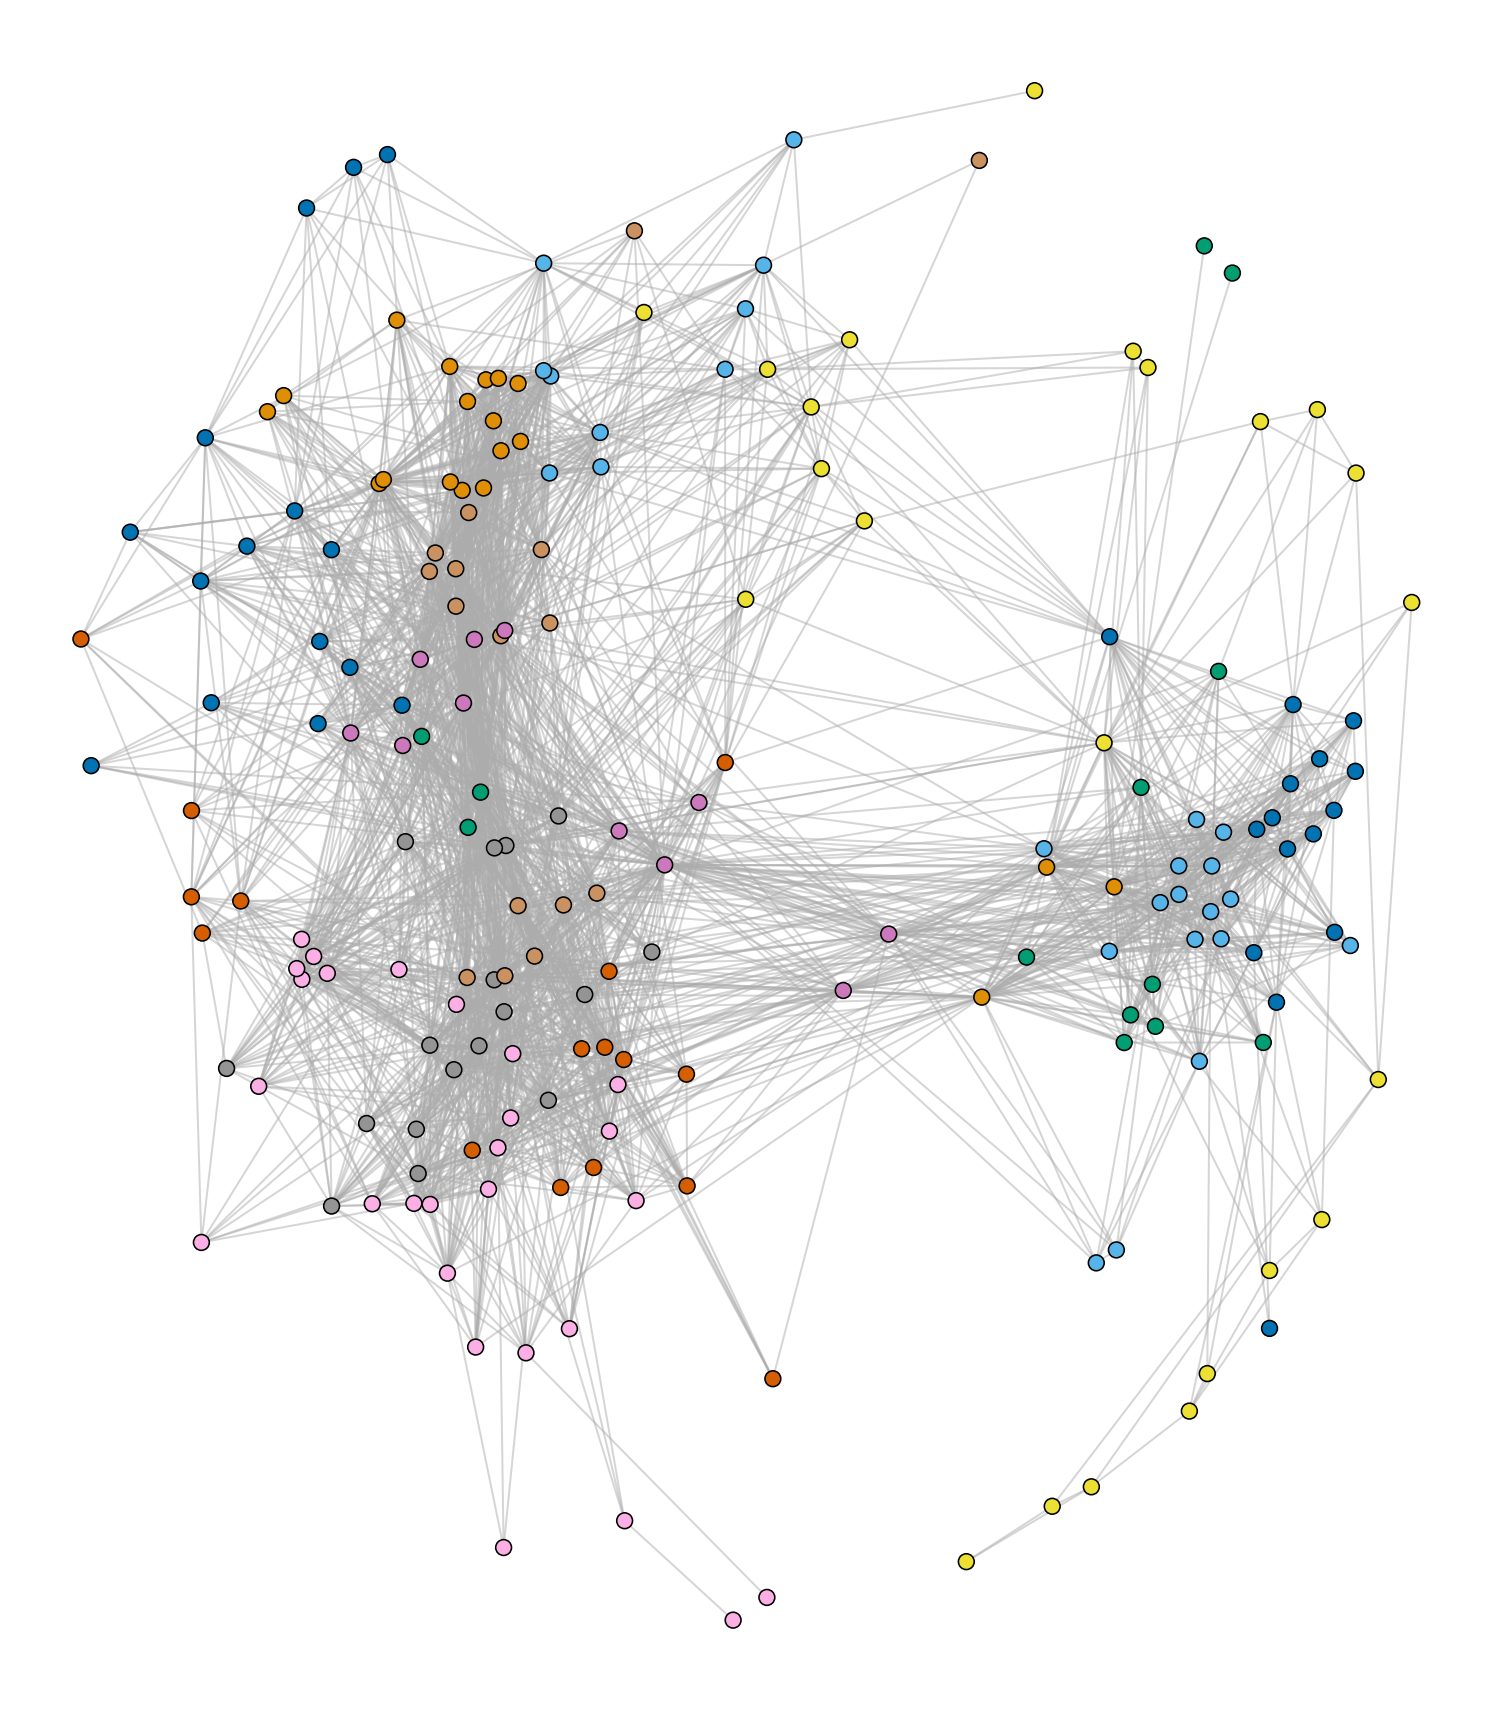

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))

arf.plot_nodes(ax, size=250, categories=heb.block_levels[0], edgecolor='black')
arf.plot_edges(ax, color='#abacab', alpha=0.5)

ax.set_axis_off()
ax.set_aspect('equal')
fig.tight_layout()

Noten que los nodos que pertenecen a una misma comunidad tienden a aparecer cerca, pero no siempre lo están. Dos nodos que se vean cercanos pueden pertenecer a comunidades distintas. Por eso debemos tener cuidado al interpretar los gráficos `node_link`: ¡recuerden que las posiciones de los nodos y los largos de las aristas obedecen a criterios estéticos de los algoritmos!

Lo mismo sucede con Hierarchical Edge Bundling: las comunidades dependen de la inicialización del algoritmo, que utiliza números generados aleatoriamente. En un análisis riguroso, el procedimiento es repetir el proceso varias veces (decenas o incluso cientos de veces), y luego utilizar un método que permita saber cuál es el modelo que presenta mejor ajuste. En el caso de `graph_tool`, esto se hace [eligiendo el modelo que genera la descripción más compacta de la red](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#the-stochastic-block-model-sbm).

Con esto terminamos esta clase.

La visualización de redes permite estudiar los datos a traves de las relaciones presentes en ellos, lo que la vuelve un buen complemento para las otras técnicas que hemos trabajado en el curso.